# Import Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Reading The Data

In [2]:
data_dir = '/kaggle/input/bitcoin-price/Bitcoin Price (2014-2023)_exported.csv'
df = pd.read_csv(data_dir, index_col='Date', parse_dates=True)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


# Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3228 entries, 2014-09-17 to 2023-07-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3228 non-null   float64
 1   High       3228 non-null   float64
 2   Low        3228 non-null   float64
 3   Close      3228 non-null   float64
 4   Adj Close  3228 non-null   float64
 5   Volume     3228 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 176.5 KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3228.000000,3228.000000,3228.000000,3228.000000,3228.000000,3.228000e+03
mean,13664.725548,13997.728538,13300.725867,13672.568197,13672.568197,1.656613e+10
std,16018.010041,16418.141665,15561.618968,16015.763332,16015.763332,1.949084e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,762.625244,773.658493,750.296265,764.113251,764.113251,1.304910e+08
50%,7688.712403,7915.482666,7511.864746,7697.924072,7697.924072,1.019161e+10
75%,20282.866699,20754.581543,19902.022949,20297.028808,20297.028808,2.742777e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


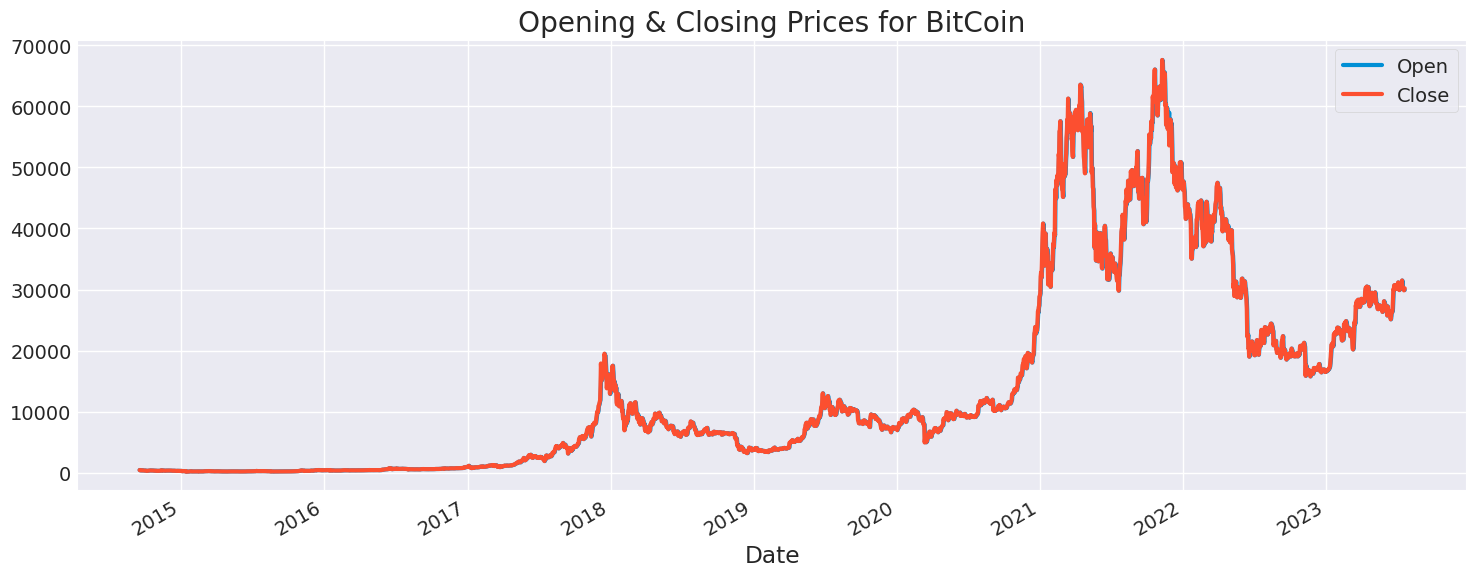

In [11]:
plt.figure(figsize=(15,6))
df['Open'].plot(linewidth=3)
df['Close'].plot(linewidth=3)
plt.title('Opening & Closing Prices for BitCoin')
plt.legend()
plt.tight_layout()
plt.show()

## Create a dataframe with date and close columns

In [14]:
df = df['Close']
df = pd.DataFrame(df) 
df.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [15]:
df.shape

(3228, 1)

## Normalizing Data

In [18]:
df.values

array([[  457.334015],
       [  424.440002],
       [  394.79599 ],
       ...,
       [30145.888672],
       [29856.5625  ],
       [30189.902344]])

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(df.values).reshape(-1,1))

## Splitting The Data

In [20]:
# 75% to Train, 25% to Test
train_size = int(len(df) * .75)
test_size = len(df) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[:train_size, 0:1]
test_data = scaled_data[train_size-60: , 0:1]

Train Size : 2421 Test Size : 807


In [21]:
train_data.shape, test_data.shape

((2421, 1), (867, 1))

## Creating Training Set

In [23]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60: i ,0])
    y_train.append(train_data[i,0])

In [24]:
# Convert to numpy array 
x_train, y_train = np.array(x_train), np.array(y_train)

In [25]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [26]:
x_train.shape, y_train.shape

((2361, 60, 1), (2361,))

# LSTM Model

## Model Structure

In [27]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)),
    LSTM(50, return_sequences=False),
    
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss= 'mse', metrics=['mean_absolute_error'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,777 (128.04 KB)

 Trainable params: 32,777 (128.04 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [29]:
early_stopping = EarlyStopping(
    patience=10,
    monitor='loss',
    restore_best_weights=True
)

In [30]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=early_stopping)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0101 - mean_absolute_error: 0.0566
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 3.5868e-04 - mean_absolute_error: 0.0099
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 3.0805e-04 - mean_absolute_error: 0.0097
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 4.0263e-04 - mean_absolute_error: 0.0126
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.9931e-04 - mean_absolute_error: 0.0094
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.3104e-04 - mean_absolute_error: 0.0095
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.5034e-04 - mean_absolute_error: 0.0091
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 2.1186e-04 - mean_absolute_error: 0.0076
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.4441e-04 - mean_absolute_error: 0.0089
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.9805e-04 - mean_absolute_error: 

## Model Evaluation

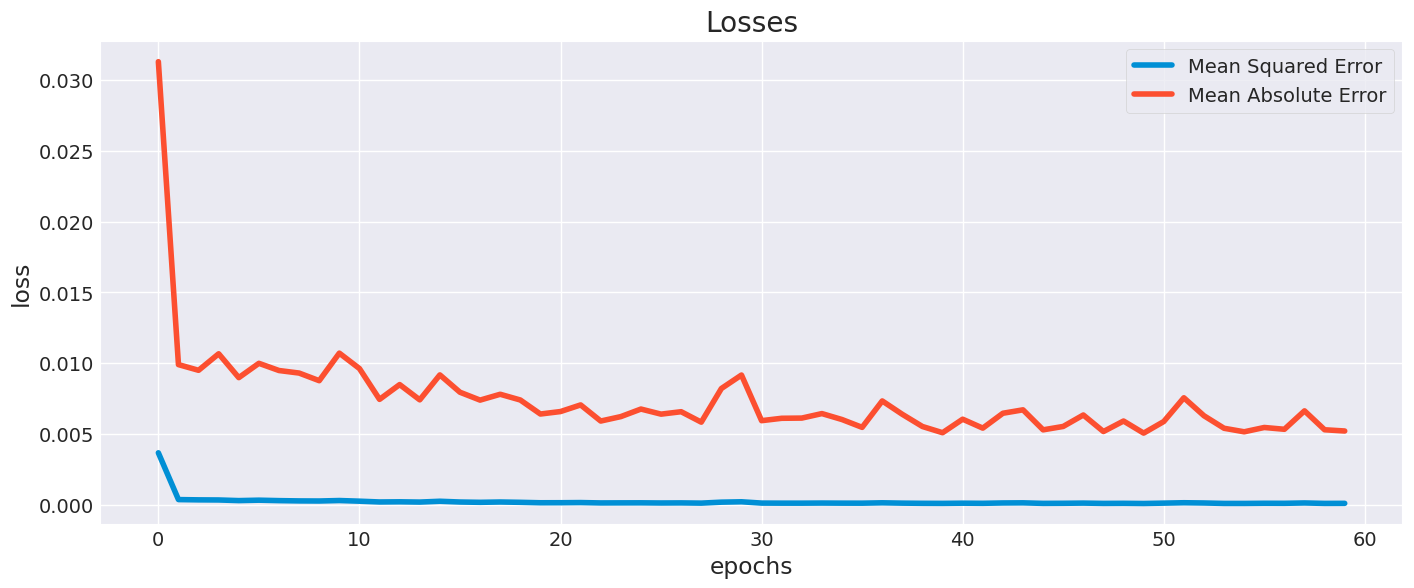

In [31]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Mean Squared Error', 'Mean Absolute Error'])
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Predection

### Creating testing set

In [32]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
x_test.shape, y_test.shape

((807, 60, 1), (807,))

In [34]:
# inverse y_test scaling 
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


(807, 1)

## Root mean square error

In [40]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean(y_test - predictions)**2).round(2)
RMSE

800.55

## Visualize Predictions with The Data

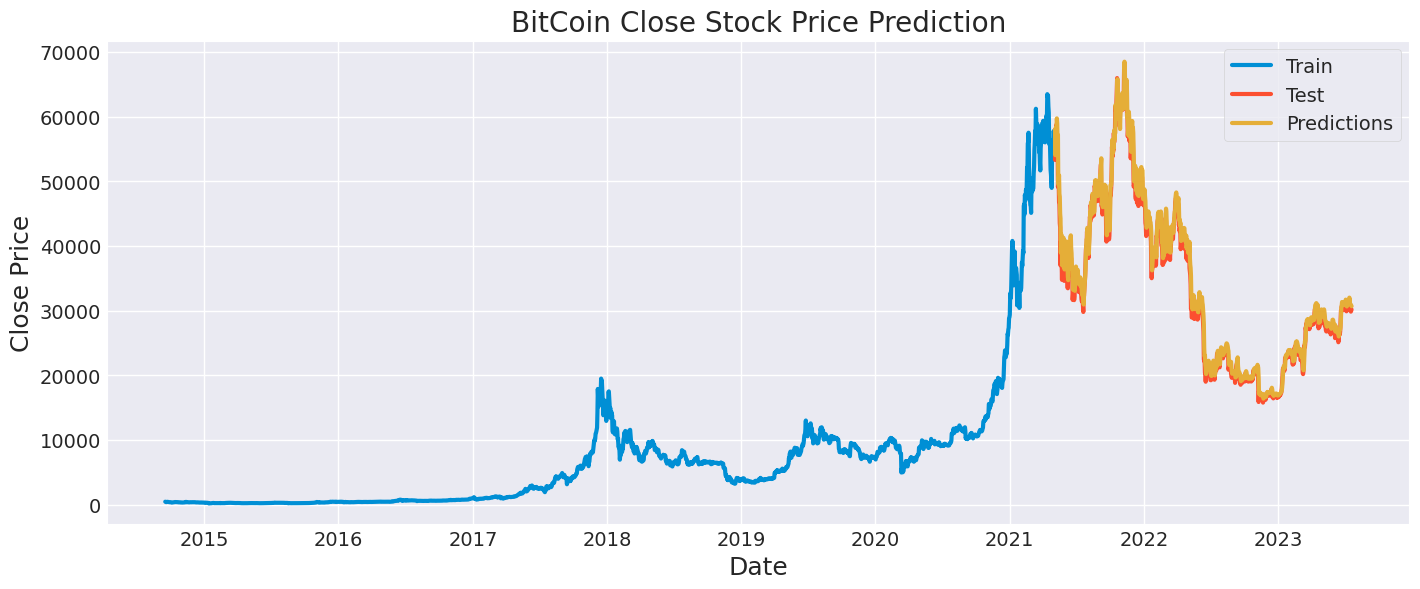

In [45]:
train = df.iloc[:train_size, 0:1]
test = df.iloc[train_size:, 0:1]
test['Predictions'] = predictions

plt.figure(figsize=(15,6))
plt.title('BitCoin Close Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'], linewidth=3)
plt.plot(test['Close'], linewidth=3)
plt.plot(test['Predictions'], linewidth=3)
plt.legend(['Train', 'Test', 'Predictions'])

# Forecast Next 30 Days

In [46]:
from datetime import timedelta

In [47]:
def insert_end(Xin, new_input):
    timestep = 60 
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep-1, :] = new_input
    return Xin

In [48]:
future = 30
forecast = []
Xin = x_test[-1:, :, :]
time = []

for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forecast.append(out[0,0])
    print(forecast)
    Xin = insert_end(Xin, out[0,0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.4528786]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.4528786, 0.46220005]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.4528786, 0.46220005, 0.47289243]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.4528786, 0.46220005, 0.47289243, 0.48407027]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.4528786, 0.46220005, 0.47289243, 0.48407027, 0.49544105]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.4528786, 0.46220005, 0.47289243, 0.48407027, 0.49544105, 0.50684714]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.4528786, 0.46220005, 0.47289243, 0.48407027, 0.49544105, 0.50684714, 0.5182096]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.4528786, 0.46220005, 0.47289243, 0.48407027, 0.49544105, 0.50684714, 0.5182096, 0.52948874]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[0.4528786, 0.46220005, 0.47289243, 0.48407027, 0.49544105, 0.50684714, 0.5182096, 0.52948874, 0.54065937]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.4528786, 0.46220005, 0.47289243, 0.48407027, 0.49544105, 0.50684714, 0.5182096, 

In [49]:
time

[Timestamp('2023-07-20 00:00:00'),
 Timestamp('2023-07-21 00:00:00'),
 Timestamp('2023-07-22 00:00:00'),
 Timestamp('2023-07-23 00:00:00'),
 Timestamp('2023-07-24 00:00:00'),
 Timestamp('2023-07-25 00:00:00'),
 Timestamp('2023-07-26 00:00:00'),
 Timestamp('2023-07-27 00:00:00'),
 Timestamp('2023-07-28 00:00:00'),
 Timestamp('2023-07-29 00:00:00'),
 Timestamp('2023-07-30 00:00:00'),
 Timestamp('2023-07-31 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-08-02 00:00:00'),
 Timestamp('2023-08-03 00:00:00'),
 Timestamp('2023-08-04 00:00:00'),
 Timestamp('2023-08-05 00:00:00'),
 Timestamp('2023-08-06 00:00:00'),
 Timestamp('2023-08-07 00:00:00'),
 Timestamp('2023-08-08 00:00:00'),
 Timestamp('2023-08-09 00:00:00'),
 Timestamp('2023-08-10 00:00:00'),
 Timestamp('2023-08-11 00:00:00'),
 Timestamp('2023-08-12 00:00:00'),
 Timestamp('2023-08-13 00:00:00'),
 Timestamp('2023-08-14 00:00:00'),
 Timestamp('2023-08-15 00:00:00'),
 Timestamp('2023-08-16 00:00:00'),
 Timestamp('2023-08-

In [50]:
forecast

[0.4528786,
 0.46220005,
 0.47289243,
 0.48407027,
 0.49544105,
 0.50684714,
 0.5182096,
 0.52948874,
 0.54065937,
 0.55169606,
 0.5625684,
 0.57324123,
 0.58367795,
 0.59384537,
 0.6037174,
 0.6132777,
 0.62252104,
 0.6314539,
 0.6400931,
 0.64846367,
 0.6565974,
 0.66452986,
 0.6722984,
 0.6799399,
 0.68748945,
 0.6949781,
 0.70243186,
 0.7098719,
 0.7173129,
 0.72476363]

## Create Forecasted Dataframe

In [54]:
forecasted_output = np.array(forecast).reshape(-1,1)
forecasted_output = scaler.inverse_transform(forecasted_output)

In [55]:
forecasted_output = pd.DataFrame(forecasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date, forecasted_output], axis=1)
df_result.columns = 'Date', 'Forecasted'

## Forecasted BitCoin close price

In [56]:
df_result

,Date,Forecasted
0,2023-07-20,30697.015625
1,2023-07-21,31325.175781
2,2023-07-22,32045.722656
3,2023-07-23,32798.980469
4,2023-07-24,33565.246094
5,2023-07-25,34333.886719
6,2023-07-26,35099.585938
7,2023-07-27,35859.675781
8,2023-07-28,36612.449219
9,2023-07-29,37356.199219


In [57]:
df_result.set_index('Date', inplace=True)

In [58]:
df_result

,Forecasted
Date,
2023-07-20,30697.015625
2023-07-21,31325.175781
2023-07-22,32045.722656
2023-07-23,32798.980469
2023-07-24,33565.246094
2023-07-25,34333.886719
2023-07-26,35099.585938
2023-07-27,35859.675781
2023-07-28,36612.449219


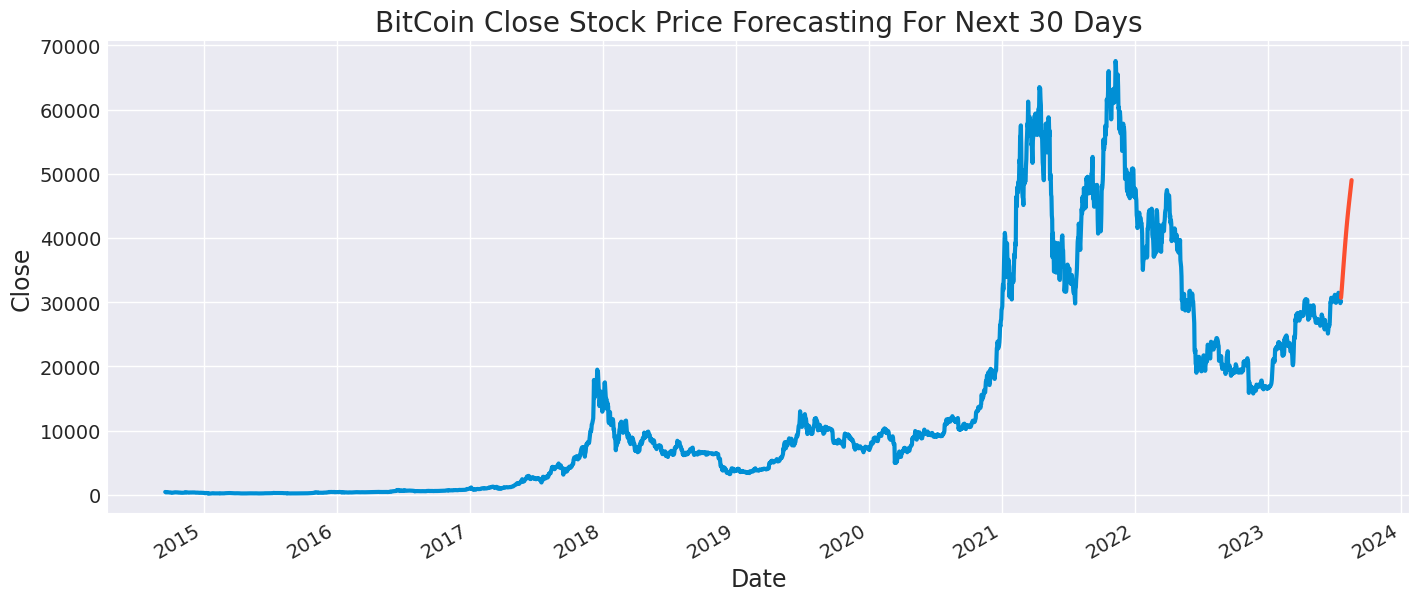

In [59]:
plt.figure(figsize=(15,7))
df['Close'].plot(linewidth=3)
df_result['Forecasted'].plot(linewidth=3)
plt.title('BitCoin Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize = 17)
plt.ylabel('Close', fontsize = 17)
plt.show()